# DeepShroom

## California mushroom classifier

Mushroom hunting is my favorite hobby. Because building a machine learning model with a dataset makes you learn about the data you're modeling, I've decided to build a mushroom image classifier to help me expand my knowledge of the mycoverse.

After looking online for a good datasource, I came across, quite frankly, a machine learning practitioner's dream datasouce (for mushrooms!). The site is the Mushroom Observer (mushroomobserver.org). They make a large csv available for ML researchers that specifies the image link, the type of mushroom, the date it was collected, and so on. So, we'll use this csv to identify mushrooms with at least 100 observations, and cross reference that against a short list of common California mushrooms.

Mushroom Observer has a surprisingly well documented API here: `https://github.com/MushroomObserver/mushroom-observer/blob/master/README_API.md`.

In [2]:
from fastai.vision.all import *

In [11]:
PATH = Path('/home/rory/Dropbox/Photos/mushrooms')

!ls /home/rory/Dropbox/Photos/mushrooms

'California Mushrooms identification flowchart 1.jpeg'	 ims
'California Mushrooms identification flowchart 2.jpeg'	 _info.txt
 Dec1ForaySpecies.xlsx					 MO_ML_images.tsv
'foray quick star list McLaren Park 2019.pdf'


In [12]:
df = pd.read_csv(PATH/'MO_ML_images.tsv', sep='\t')
df

,link,id,mushroom,created,photographer
0,https://mushroomobserver.org/images/640/2.jpg,2,Xylaria magnoliae,2004-07-17,Nathan Wilson
1,https://mushroomobserver.org/images/640/16.jpg,16,Volvopluteus gloiocephalus,2005-01-07,Nathan Wilson
2,https://mushroomobserver.org/images/640/26.jpg,26,Panellus stipticus,2004-11-26,Nathan Wilson
3,https://mushroomobserver.org/images/640/36.jpg,36,Sutorius eximius,2004-07-14,Nathan Wilson
4,https://mushroomobserver.org/images/640/37.jpg,37,Harrya chromapes,1994-09-15,Nathan Wilson
...,...,...,...,...,...
254915,https://mushroomobserver.org/images/640/1314326.jpg,1314326,Amanita velosa,2021-03-10,James Baker
254916,https://mushroomobserver.org/images/640/1314327.jpg,1314327,Amanita velosa,2021-03-10,James Baker
254917,https://mushroomobserver.org/images/640/1314375.jpg,1314375,Laricifomes officinalis,2021-03-10,-Josh
254918,https://mushroomobserver.org/images/640/1314376.jpg,1314376,Laricifomes officinalis,2021-03-10,-Josh


In [14]:
value_counts = df['mushroom'].value_counts()
value_counts

Russula                     2694
Cortinarius                 1781
Psilocybe zapotecorum       1317
Trametes versicolor         1251
Psilocybe pelliculosa       1209
                            ... 
Nephroma expallidum            1
Pertusaria globularis          1
Phaeophyscia constipata        1
Bathelium carolinianum         1
Neofavolus cremeoalbidus       1
Name: mushroom, Length: 7754, dtype: int64

I got this shortlist by looking at some MSSF docs. I'm sure it isn't complete, plus I've identified some spelling mistakes here and there which I've tried to correct. (Everything should be properly spelled now!).

In [15]:
shortlist = L(
    'Agaricus', 'Agaricus californicus', 'Agaricus hondensis', 'Agaricus xanthodermus',
    'Amanita ocreata', 'Amanita phalloides', 'Amanita gemmata', 'Amanita muscaria', 'Amanita pantherina',
    'Armillaria mellea',
    'Bolbitius titubans',
    'Boletus edulis',
    'Bovista plumbea',
    'Chlorophyllum brunneum', 'Chlorophyllum molybdites',
    'Chroogomphus vinicolor',
    'Clitocybe rivulosa',
    'Coprinopsis atramentaria',
    'Cortinarius croceus', 'Cortinarius orellanus',
    'Crepidotus mollis',
    'Coprinellus micaceus',
    'Entoloma',
    'Galerina marginata',
    'Gymnopilus junonius', 'Gymnopilus luteofolius',
    'Gyromitra esculenta', 'Gyromitra infula',
    'Hebeloma crustuliniforme',
    'Helvella vespertina',
    'Hygrophorus gliocyclus',
    'Hypholoma fasciculare',
    'Laccaria amethysteo-occidentalis',
    'Lactarius alnicola', 'Lactarius deliciosus', 'Lactarius rubidus', 'Lactarius xanthogalactus',
    'Laetiporus gilbertsonii',
    'Lepiota subincarnata',
    'Leratiomyces ceres',
    'Leucopaxillus albissimus',
    'Mycena pura', 'Mycena purpureofusca',
    'Omphalotus olivascens',
    'Paxillus involutus',
    'Peziza',
    'Phaeolus schweinitzii',
    'Pholiotina rugosa',
    'Pluteus cervinus',
    'Postia',
    'Psilocybe cyanescens',
    'Rubroboletus eastwoodiae',
    'Russula sanguinea',
    'Sparassis radicata',
    'Stereum hirsutum',
    'Suillus pungens',
    'Tapinella panuoides',
    'Trametes versicolor',
    'Tricholoma myomyces'
)

shortlist.filter(lambda x: x not in value_counts.index)

(#4) ['Amanita gemmata','Cortinarius orellanus','Gymnopilus luteofolius','Tricholoma myomyces']

Those four will have to have images scraped from mushroomobserver.org – images exist, but they aren't in the precompiled list. I'll also throw out the genus-only groups b/c I'm not sure how clean they are.

In [16]:
binomials = shortlist.filter(lambda x: ' ' in x)
binomials

(#55) ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita ocreata','Amanita phalloides','Amanita gemmata','Amanita muscaria','Amanita pantherina','Armillaria mellea','Bolbitius titubans'...]

I'll start by focussing on classifying shrooms with 100+ images in this starting set.

In [17]:
in_shortlist = value_counts.index.isin(binomials)
at_least_100 = value_counts.values >= 100

keepers = value_counts[in_shortlist & at_least_100].index.to_numpy()
keepers

array(['Trametes versicolor', 'Psilocybe cyanescens',
       'Galerina marginata', 'Amanita phalloides',
       'Phaeolus schweinitzii', 'Chlorophyllum molybdites',
       'Hypholoma fasciculare', 'Armillaria mellea', 'Leratiomyces ceres',
       'Agaricus xanthodermus', 'Pluteus cervinus',
       'Coprinellus micaceus', 'Bolbitius titubans', 'Paxillus involutus',
       'Laccaria amethysteo-occidentalis', 'Lactarius rubidus',
       'Amanita muscaria', 'Gyromitra esculenta', 'Omphalotus olivascens',
       'Chlorophyllum brunneum', 'Boletus edulis', 'Stereum hirsutum',
       'Amanita ocreata', 'Laetiporus gilbertsonii',
       'Tapinella panuoides', 'Mycena pura', 'Lactarius xanthogalactus',
       'Gyromitra infula', 'Suillus pungens', 'Crepidotus mollis',
       'Lactarius alnicola', 'Helvella vespertina',
       'Coprinopsis atramentaria', 'Hebeloma crustuliniforme',
       'Agaricus hondensis', 'Mycena purpureofusca', 'Sparassis radicata',
       'Chroogomphus vinicolor', 'Gymnop

In [9]:
filtered_df = df.loc[df['mushroom'].isin(keepers)].copy()
filtered_df

,link,id,mushroom,created,photographer
12,https://mushroomobserver.org/images/640/67.jpg,67,Trametes versicolor,2002-01-08,Nathan Wilson
13,https://mushroomobserver.org/images/640/68.jpg,68,Trametes versicolor,2002-01-08,Nathan Wilson
49,https://mushroomobserver.org/images/640/315.jpg,315,Lactarius rubidus,2002-01-09,Nathan Wilson
50,https://mushroomobserver.org/images/640/348.jpg,348,Hypholoma fasciculare,2003-12-01,Nathan Wilson
51,https://mushroomobserver.org/images/640/349.jpg,349,Hypholoma fasciculare,1993-12-15,Nathan Wilson
...,...,...,...,...,...
254873,https://mushroomobserver.org/images/640/1313482.jpg,1313482,Psilocybe cyanescens,2020-11-23,Forest Morgan
254890,https://mushroomobserver.org/images/640/1313845.jpg,1313845,Stereum hirsutum,2009-12-23,Mike Potts
254894,https://mushroomobserver.org/images/640/1313907.jpg,1313907,Agaricus xanthodermus,2010-09-03,Mike Potts
254896,https://mushroomobserver.org/images/640/1313912.jpg,1313912,Coprinellus micaceus,2011-03-11,Mike Potts


Save it!

In [42]:
filtered_df.to_csv(PATH/'filtered_df.csv', sep='\t')

# Download images

Time to download the 13,178 images (took 4hours 33min).

In [39]:
# import requests
# import shutil

# links = filtered_df['link'].to_list()

# for link in links:
#     fn = link.split("/")[-1]
    
#     r = requests.get(link, stream=True)
    
#     if r.status_code == 200:
#         r.raw.decode_content = True
#         with open(PATH/'mo'/fn,'wb') as f: shutil.copyfileobj(r.raw, f)
#         print('Success:',fn)
#     else:
#         print('FAILED:', fn)

Success: 67.jpg
Success: 68.jpg
Success: 315.jpg
Success: 348.jpg
Success: 349.jpg
Success: 351.jpg
Success: 352.jpg
Success: 399.jpg
Success: 498.jpg
Success: 503.jpg
Success: 504.jpg
Success: 505.jpg
Success: 506.jpg
Success: 507.jpg
Success: 538.jpg
Success: 539.jpg
Success: 634.jpg
Success: 635.jpg
Success: 636.jpg
Success: 637.jpg
Success: 638.jpg
Success: 639.jpg
Success: 691.jpg
Success: 716.jpg
Success: 717.jpg
Success: 750.jpg
Success: 751.jpg
Success: 767.jpg
Success: 768.jpg
Success: 779.jpg
Success: 971.jpg
Success: 795.jpg
Success: 796.jpg
Success: 844.jpg
Success: 874.jpg
Success: 945.jpg
Success: 969.jpg
Success: 970.jpg
Success: 996.jpg
Success: 1055.jpg
Success: 1073.jpg
Success: 1123.jpg
Success: 1124.jpg
Success: 1125.jpg
Success: 1262.jpg
Success: 1263.jpg
Success: 1541.jpg
Success: 1542.jpg
Success: 1589.jpg
Success: 1590.jpg
Success: 1731.jpg
Success: 2024.jpg
Success: 2025.jpg
Success: 2026.jpg
Success: 2006.jpg
Success: 2007.jpg
Success: 2011.jpg
Success: 2042.j

Success: 27195.jpg
Success: 27196.jpg
Success: 27197.jpg
Success: 27198.jpg
Success: 27199.jpg
Success: 27351.jpg
Success: 27554.jpg
Success: 27555.jpg
Success: 27873.jpg
Success: 27874.jpg
Success: 27875.jpg
Success: 27876.jpg
Success: 27977.jpg
Success: 27991.jpg
Success: 27992.jpg
Success: 27993.jpg
Success: 27994.jpg
Success: 28039.jpg
Success: 28040.jpg
Success: 28041.jpg
Success: 28042.jpg
Success: 28050.jpg
Success: 28037.jpg
Success: 28038.jpg
Success: 29666.jpg
Success: 28305.jpg
Success: 28306.jpg
Success: 28313.jpg
Success: 28314.jpg
Success: 28316.jpg
Success: 28410.jpg
Success: 28413.jpg
Success: 28414.jpg
Success: 28415.jpg
Success: 28521.jpg
Success: 28734.jpg
Success: 28735.jpg
Success: 28736.jpg
Success: 28602.jpg
Success: 28603.jpg
Success: 28660.jpg
Success: 28661.jpg
Success: 28662.jpg
Success: 28663.jpg
Success: 28664.jpg
Success: 28665.jpg
Success: 28666.jpg
Success: 28667.jpg
Success: 28668.jpg
Success: 28669.jpg
Success: 28748.jpg
Success: 28775.jpg
Success: 287

Success: 43268.jpg
Success: 43269.jpg
Success: 43270.jpg
Success: 43271.jpg
Success: 43272.jpg
Success: 43551.jpg
Success: 43552.jpg
Success: 43553.jpg
Success: 43554.jpg
Success: 43555.jpg
Success: 45483.jpg
Success: 45484.jpg
Success: 45485.jpg
Success: 43994.jpg
Success: 43995.jpg
Success: 43996.jpg
Success: 43997.jpg
Success: 43998.jpg
Success: 43999.jpg
Success: 44000.jpg
Success: 44380.jpg
Success: 44381.jpg
Success: 44382.jpg
Success: 44383.jpg
Success: 44384.jpg
Success: 44385.jpg
Success: 44386.jpg
Success: 44387.jpg
Success: 44388.jpg
Success: 44389.jpg
Success: 44576.jpg
Success: 46635.jpg
Success: 46636.jpg
Success: 47356.jpg
Success: 47357.jpg
Success: 47358.jpg
Success: 47359.jpg
Success: 47360.jpg
Success: 47361.jpg
Success: 47362.jpg
Success: 47363.jpg
Success: 48021.jpg
Success: 48022.jpg
Success: 48023.jpg
Success: 48120.jpg
Success: 48121.jpg
Success: 48122.jpg
Success: 48123.jpg
Success: 49392.jpg
Success: 49399.jpg
Success: 49633.jpg
Success: 49818.jpg
Success: 498

Success: 70295.jpg
Success: 70451.jpg
Success: 70452.jpg
Success: 70453.jpg
Success: 70594.jpg
Success: 70840.jpg
Success: 70841.jpg
Success: 70925.jpg
Success: 70926.jpg
Success: 70927.jpg
Success: 70928.jpg
Success: 70929.jpg
Success: 70930.jpg
Success: 70931.jpg
Success: 70932.jpg
Success: 70933.jpg
Success: 71029.jpg
Success: 71050.jpg
Success: 71087.jpg
Success: 71088.jpg
Success: 71089.jpg
Success: 71317.jpg
Success: 71318.jpg
Success: 71385.jpg
Success: 71519.jpg
Success: 71520.jpg
Success: 71574.jpg
Success: 71575.jpg
Success: 71576.jpg
Success: 71701.jpg
Success: 71702.jpg
Success: 71747.jpg
Success: 71748.jpg
Success: 71749.jpg
Success: 71750.jpg
Success: 71751.jpg
Success: 71752.jpg
Success: 71753.jpg
Success: 71831.jpg
Success: 71832.jpg
Success: 71833.jpg
Success: 71834.jpg
Success: 71838.jpg
Success: 71846.jpg
Success: 71854.jpg
Success: 71855.jpg
Success: 71856.jpg
Success: 71857.jpg
Success: 71858.jpg
Success: 71986.jpg
Success: 71987.jpg
Success: 71988.jpg
Success: 719

Success: 104851.jpg
Success: 104905.jpg
Success: 104906.jpg
Success: 104907.jpg
Success: 105313.jpg
Success: 105695.jpg
Success: 105696.jpg
Success: 105763.jpg
Success: 105764.jpg
Success: 105765.jpg
Success: 105766.jpg
Success: 105767.jpg
Success: 106059.jpg
Success: 106060.jpg
Success: 106061.jpg
Success: 106062.jpg
Success: 106628.jpg
Success: 106629.jpg
Success: 106630.jpg
Success: 106631.jpg
Success: 106895.jpg
Success: 106896.jpg
Success: 106897.jpg
Success: 107133.jpg
Success: 107134.jpg
Success: 107135.jpg
Success: 107353.jpg
Success: 107354.jpg
Success: 107355.jpg
Success: 107356.jpg
Success: 107357.jpg
Success: 107367.jpg
Success: 107368.jpg
Success: 107369.jpg
Success: 107370.jpg
Success: 107371.jpg
Success: 107373.jpg
Success: 107866.jpg
Success: 107867.jpg
Success: 107882.jpg
Success: 107883.jpg
Success: 108001.jpg
Success: 108136.jpg
Success: 108137.jpg
Success: 108138.jpg
Success: 108139.jpg
Success: 108419.jpg
Success: 108420.jpg
Success: 108421.jpg
Success: 108422.jpg


Success: 121250.jpg
Success: 121251.jpg
Success: 121252.jpg
Success: 121290.jpg
Success: 121291.jpg
Success: 121292.jpg
Success: 121652.jpg
Success: 121653.jpg
Success: 121654.jpg
Success: 121825.jpg
Success: 121826.jpg
Success: 121827.jpg
Success: 121955.jpg
Success: 121956.jpg
Success: 121957.jpg
Success: 121958.jpg
Success: 121959.jpg
Success: 122138.jpg
Success: 122139.jpg
Success: 122144.jpg
Success: 122145.jpg
Success: 122146.jpg
Success: 122442.jpg
Success: 122443.jpg
Success: 122492.jpg
Success: 122493.jpg
Success: 122494.jpg
Success: 122645.jpg
Success: 122646.jpg
Success: 122796.jpg
Success: 122797.jpg
Success: 122845.jpg
Success: 122846.jpg
Success: 122847.jpg
Success: 122848.jpg
Success: 122849.jpg
Success: 122850.jpg
Success: 122851.jpg
Success: 122852.jpg
Success: 123002.jpg
Success: 123003.jpg
Success: 123004.jpg
Success: 123005.jpg
Success: 123006.jpg
Success: 123039.jpg
Success: 123040.jpg
Success: 123041.jpg
Success: 123042.jpg
Success: 123043.jpg
Success: 123049.jpg


Success: 135905.jpg
Success: 135910.jpg
Success: 135911.jpg
Success: 135912.jpg
Success: 136401.jpg
Success: 136402.jpg
Success: 136403.jpg
Success: 136889.jpg
Success: 136890.jpg
Success: 136967.jpg
Success: 136968.jpg
Success: 136969.jpg
Success: 136970.jpg
Success: 137004.jpg
Success: 137005.jpg
Success: 137006.jpg
Success: 137013.jpg
Success: 137014.jpg
Success: 137015.jpg
Success: 137016.jpg
Success: 137426.jpg
Success: 137555.jpg
Success: 137829.jpg
Success: 137851.jpg
Success: 137930.jpg
Success: 137931.jpg
Success: 137932.jpg
Success: 138030.jpg
Success: 138032.jpg
Success: 138033.jpg
Success: 138138.jpg
Success: 138139.jpg
Success: 138140.jpg
Success: 138141.jpg
Success: 138228.jpg
Success: 138229.jpg
Success: 138269.jpg
Success: 138270.jpg
Success: 138271.jpg
Success: 138361.jpg
Success: 138381.jpg
Success: 138382.jpg
Success: 138525.jpg
Success: 138526.jpg
Success: 138527.jpg
Success: 138528.jpg
Success: 138529.jpg
Success: 138923.jpg
Success: 138924.jpg
Success: 138960.jpg


Success: 170482.jpg
Success: 170483.jpg
Success: 170484.jpg
Success: 170628.jpg
Success: 170826.jpg
Success: 170827.jpg
Success: 170828.jpg
Success: 170829.jpg
Success: 170830.jpg
Success: 218744.jpg
Success: 218745.jpg
Success: 218746.jpg
Success: 218747.jpg
Success: 218802.jpg
Success: 214134.jpg
Success: 214135.jpg
Success: 214136.jpg
Success: 214137.jpg
Success: 170993.jpg
Success: 170994.jpg
Success: 170995.jpg
Success: 170996.jpg
Success: 171258.jpg
Success: 171259.jpg
Success: 171122.jpg
Success: 171123.jpg
Success: 171124.jpg
Success: 171125.jpg
Success: 171126.jpg
Success: 171412.jpg
Success: 171413.jpg
Success: 171770.jpg
Success: 171780.jpg
Success: 171781.jpg
Success: 171991.jpg
Success: 171992.jpg
Success: 171993.jpg
Success: 172213.jpg
Success: 172214.jpg
Success: 172407.jpg
Success: 173893.jpg
Success: 173894.jpg
Success: 172676.jpg
Success: 172722.jpg
Success: 172914.jpg
Success: 172915.jpg
Success: 172916.jpg
Success: 172917.jpg
Success: 173255.jpg
Success: 173256.jpg


Success: 190092.jpg
Success: 190093.jpg
Success: 190094.jpg
Success: 190095.jpg
Success: 190304.jpg
Success: 190404.jpg
Success: 190405.jpg
Success: 191204.jpg
Success: 191205.jpg
Success: 191206.jpg
Success: 191207.jpg
Success: 191208.jpg
Success: 191475.jpg
Success: 191476.jpg
Success: 191477.jpg
Success: 191478.jpg
Success: 191479.jpg
Success: 191735.jpg
Success: 191736.jpg
Success: 191737.jpg
Success: 191738.jpg
Success: 192047.jpg
Success: 192048.jpg
Success: 192068.jpg
Success: 192070.jpg
Success: 192066.jpg
Success: 192067.jpg
Success: 192139.jpg
Success: 192372.jpg
Success: 192373.jpg
Success: 192582.jpg
Success: 192666.jpg
Success: 192676.jpg
Success: 192677.jpg
Success: 192678.jpg
Success: 193049.jpg
Success: 193050.jpg
Success: 193964.jpg
Success: 193965.jpg
Success: 193966.jpg
Success: 193967.jpg
Success: 193968.jpg
Success: 193969.jpg
Success: 193970.jpg
Success: 193971.jpg
Success: 193972.jpg
Success: 193973.jpg
Success: 193974.jpg
Success: 193975.jpg
Success: 193976.jpg


Success: 225483.jpg
Success: 225484.jpg
Success: 225809.jpg
Success: 226943.jpg
Success: 226944.jpg
Success: 226954.jpg
Success: 226955.jpg
Success: 227128.jpg
Success: 227129.jpg
Success: 229639.jpg
Success: 229640.jpg
Success: 229641.jpg
Success: 231287.jpg
Success: 231288.jpg
Success: 227392.jpg
Success: 227393.jpg
Success: 227394.jpg
Success: 227395.jpg
Success: 227441.jpg
Success: 227493.jpg
Success: 227494.jpg
Success: 227495.jpg
Success: 227496.jpg
Success: 227507.jpg
Success: 227508.jpg
Success: 227509.jpg
Success: 227510.jpg
Success: 227887.jpg
Success: 227888.jpg
Success: 227889.jpg
Success: 227890.jpg
Success: 227891.jpg
Success: 227914.jpg
Success: 227915.jpg
Success: 227919.jpg
Success: 228016.jpg
Success: 228017.jpg
Success: 228644.jpg
Success: 228645.jpg
Success: 228710.jpg
Success: 228711.jpg
Success: 228712.jpg
Success: 228713.jpg
Success: 228714.jpg
Success: 228894.jpg
Success: 228895.jpg
Success: 228896.jpg
Success: 229322.jpg
Success: 229323.jpg
Success: 229324.jpg


Success: 283200.jpg
Success: 283201.jpg
Success: 283202.jpg
Success: 283321.jpg
Success: 283322.jpg
Success: 283459.jpg
Success: 283460.jpg
Success: 283461.jpg
Success: 283710.jpg
Success: 283711.jpg
Success: 283712.jpg
Success: 284014.jpg
Success: 284021.jpg
Success: 284022.jpg
Success: 284146.jpg
Success: 284345.jpg
Success: 284346.jpg
Success: 284585.jpg
Success: 284698.jpg
Success: 284699.jpg
Success: 284847.jpg
Success: 285928.jpg
Success: 285929.jpg
Success: 285930.jpg
Success: 285931.jpg
Success: 284864.jpg
Success: 284865.jpg
Success: 284866.jpg
Success: 284867.jpg
Success: 284868.jpg
Success: 285949.jpg
Success: 285950.jpg
Success: 285416.jpg
Success: 285449.jpg
Success: 285450.jpg
Success: 285586.jpg
Success: 285587.jpg
Success: 285861.jpg
Success: 285862.jpg
Success: 285871.jpg
Success: 285872.jpg
Success: 285873.jpg
Success: 285874.jpg
Success: 285883.jpg
Success: 285884.jpg
Success: 285885.jpg
Success: 285886.jpg
Success: 285994.jpg
Success: 285995.jpg
Success: 285996.jpg


Success: 306457.jpg
Success: 306458.jpg
Success: 306459.jpg
Success: 307707.jpg
Success: 307708.jpg
Success: 308031.jpg
Success: 308032.jpg
Success: 308323.jpg
Success: 308324.jpg
Success: 308325.jpg
Success: 308326.jpg
Success: 308327.jpg
Success: 308328.jpg
Success: 308329.jpg
Success: 308462.jpg
Success: 308819.jpg
Success: 308820.jpg
Success: 308821.jpg
Success: 309206.jpg
Success: 309207.jpg
Success: 309208.jpg
Success: 309209.jpg
Success: 309210.jpg
Success: 309211.jpg
Success: 309212.jpg
Success: 309490.jpg
Success: 309491.jpg
Success: 309492.jpg
Success: 309493.jpg
Success: 309494.jpg
Success: 309495.jpg
Success: 309682.jpg
Success: 309683.jpg
Success: 309730.jpg
Success: 309731.jpg
Success: 309740.jpg
Success: 311244.jpg
Success: 311245.jpg
Success: 311246.jpg
Success: 311247.jpg
Success: 311248.jpg
Success: 311351.jpg
Success: 311352.jpg
Success: 311353.jpg
Success: 311354.jpg
Success: 311355.jpg
Success: 311356.jpg
Success: 311699.jpg
Success: 311700.jpg
Success: 311701.jpg


Success: 362320.jpg
Success: 362321.jpg
Success: 362891.jpg
Success: 362974.jpg
Success: 362975.jpg
Success: 362976.jpg
Success: 362977.jpg
Success: 363386.jpg
Success: 363387.jpg
Success: 363388.jpg
Success: 363389.jpg
Success: 363390.jpg
Success: 364335.jpg
Success: 364336.jpg
Success: 364337.jpg
Success: 365042.jpg
Success: 365061.jpg
Success: 365062.jpg
Success: 365063.jpg
Success: 365064.jpg
Success: 365065.jpg
Success: 365066.jpg
Success: 365067.jpg
Success: 365950.jpg
Success: 365951.jpg
Success: 365952.jpg
Success: 365953.jpg
Success: 366215.jpg
Success: 366216.jpg
Success: 366104.jpg
Success: 366105.jpg
Success: 366106.jpg
Success: 366107.jpg
Success: 366108.jpg
Success: 366418.jpg
Success: 367721.jpg
Success: 367722.jpg
Success: 367723.jpg
Success: 367724.jpg
Success: 367725.jpg
Success: 368400.jpg
Success: 368401.jpg
Success: 368402.jpg
Success: 368641.jpg
Success: 368642.jpg
Success: 368643.jpg
Success: 368781.jpg
Success: 369001.jpg
Success: 369330.jpg
Success: 369331.jpg


Success: 392302.jpg
Success: 392303.jpg
Success: 392866.jpg
Success: 392867.jpg
Success: 393271.jpg
Success: 393272.jpg
Success: 393429.jpg
Success: 393562.jpg
Success: 393563.jpg
Success: 393745.jpg
Success: 393746.jpg
Success: 393747.jpg
Success: 393748.jpg
Success: 393749.jpg
Success: 393750.jpg
Success: 393771.jpg
Success: 393772.jpg
Success: 393773.jpg
Success: 393973.jpg
Success: 393974.jpg
Success: 393975.jpg
Success: 393976.jpg
Success: 393977.jpg
Success: 393978.jpg
Success: 393979.jpg
Success: 393980.jpg
Success: 393981.jpg
Success: 394109.jpg
Success: 394110.jpg
Success: 394112.jpg
Success: 394760.jpg
Success: 394761.jpg
Success: 394762.jpg
Success: 394763.jpg
Success: 394764.jpg
Success: 394922.jpg
Success: 394923.jpg
Success: 394924.jpg
Success: 394925.jpg
Success: 394926.jpg
Success: 394927.jpg
Success: 395731.jpg
Success: 395732.jpg
Success: 395733.jpg
Success: 395734.jpg
Success: 395735.jpg
Success: 395736.jpg
Success: 395737.jpg
Success: 396206.jpg
Success: 396207.jpg


Success: 450545.jpg
Success: 450546.jpg
Success: 450554.jpg
Success: 450796.jpg
Success: 450797.jpg
Success: 450798.jpg
Success: 450799.jpg
Success: 450800.jpg
Success: 450801.jpg
Success: 451398.jpg
Success: 451399.jpg
Success: 451400.jpg
Success: 452381.jpg
Success: 452382.jpg
Success: 452383.jpg
Success: 452384.jpg
Success: 453959.jpg
Success: 453960.jpg
Success: 453961.jpg
Success: 455328.jpg
Success: 455329.jpg
Success: 455330.jpg
Success: 455331.jpg
Success: 455332.jpg
Success: 455333.jpg
Success: 455334.jpg
Success: 455335.jpg
Success: 455336.jpg
Success: 455340.jpg
Success: 455341.jpg
Success: 455342.jpg
Success: 451350.jpg
Success: 451351.jpg
Success: 457333.jpg
Success: 453748.jpg
Success: 453756.jpg
Success: 452354.jpg
Success: 452403.jpg
Success: 452415.jpg
Success: 453114.jpg
Success: 453423.jpg
Success: 451783.jpg
Success: 452134.jpg
Success: 452135.jpg
Success: 452136.jpg
Success: 452137.jpg
Success: 452138.jpg
Success: 452139.jpg
Success: 452254.jpg
Success: 452255.jpg


Success: 479853.jpg
Success: 479854.jpg
Success: 479856.jpg
Success: 479857.jpg
Success: 479858.jpg
Success: 479859.jpg
Success: 479862.jpg
Success: 479863.jpg
Success: 479864.jpg
Success: 479865.jpg
Success: 480486.jpg
Success: 480487.jpg
Success: 480488.jpg
Success: 480621.jpg
Success: 480622.jpg
Success: 480623.jpg
Success: 480624.jpg
Success: 480625.jpg
Success: 480626.jpg
Success: 480627.jpg
Success: 480628.jpg
Success: 480629.jpg
Success: 480630.jpg
Success: 480631.jpg
Success: 480632.jpg
Success: 480633.jpg
Success: 480634.jpg
Success: 480635.jpg
Success: 480813.jpg
Success: 480814.jpg
Success: 480799.jpg
Success: 480802.jpg
Success: 480803.jpg
Success: 480807.jpg
Success: 481101.jpg
Success: 481171.jpg
Success: 481172.jpg
Success: 481173.jpg
Success: 481273.jpg
Success: 481274.jpg
Success: 481275.jpg
Success: 481276.jpg
Success: 481277.jpg
Success: 481278.jpg
Success: 481279.jpg
Success: 481530.jpg
Success: 481531.jpg
Success: 481532.jpg
Success: 481533.jpg
Success: 481534.jpg


Success: 518443.jpg
Success: 518444.jpg
Success: 518707.jpg
Success: 518708.jpg
Success: 519894.jpg
Success: 519898.jpg
Success: 520215.jpg
Success: 520524.jpg
Success: 520917.jpg
Success: 520919.jpg
Success: 520920.jpg
Success: 521466.jpg
Success: 521467.jpg
Success: 521468.jpg
Success: 521469.jpg
Success: 521470.jpg
Success: 522294.jpg
Success: 522295.jpg
Success: 522784.jpg
Success: 522785.jpg
Success: 523005.jpg
Success: 523068.jpg
Success: 523734.jpg
Success: 523735.jpg
Success: 523755.jpg
Success: 524527.jpg
Success: 524528.jpg
Success: 524950.jpg
Success: 524951.jpg
Success: 524952.jpg
Success: 525778.jpg
Success: 525779.jpg
Success: 525780.jpg
Success: 525781.jpg
Success: 526274.jpg
Success: 526275.jpg
Success: 528687.jpg
Success: 528688.jpg
Success: 528689.jpg
Success: 528690.jpg
Success: 529949.jpg
Success: 529951.jpg
Success: 529952.jpg
Success: 530704.jpg
Success: 531462.jpg
Success: 531464.jpg
Success: 532086.jpg
Success: 532087.jpg
Success: 532278.jpg
Success: 532279.jpg


Success: 573135.jpg
Success: 573136.jpg
Success: 573591.jpg
Success: 573592.jpg
Success: 573593.jpg
Success: 573781.jpg
Success: 573839.jpg
Success: 573840.jpg
Success: 573982.jpg
Success: 573983.jpg
Success: 574114.jpg
Success: 574115.jpg
Success: 574116.jpg
Success: 574117.jpg
Success: 574118.jpg
Success: 574119.jpg
Success: 574120.jpg
Success: 574140.jpg
Success: 574141.jpg
Success: 574143.jpg
Success: 574144.jpg
Success: 574244.jpg
Success: 575028.jpg
Success: 575029.jpg
Success: 575030.jpg
Success: 575031.jpg
Success: 575219.jpg
Success: 575220.jpg
Success: 575681.jpg
Success: 575682.jpg
Success: 575683.jpg
Success: 575684.jpg
Success: 575693.jpg
Success: 575694.jpg
Success: 575789.jpg
Success: 575790.jpg
Success: 575848.jpg
Success: 576500.jpg
Success: 576856.jpg
Success: 576857.jpg
Success: 576858.jpg
Success: 576859.jpg
Success: 576893.jpg
Success: 576894.jpg
Success: 576895.jpg
Success: 651944.jpg
Success: 651945.jpg
Success: 577344.jpg
Success: 577345.jpg
Success: 577792.jpg


Success: 599406.jpg
Success: 599407.jpg
Success: 599408.jpg
Success: 599409.jpg
Success: 599410.jpg
Success: 599411.jpg
Success: 599412.jpg
Success: 599721.jpg
Success: 599722.jpg
Success: 600635.jpg
Success: 600952.jpg
Success: 600953.jpg
Success: 601041.jpg
Success: 601042.jpg
Success: 601043.jpg
Success: 601850.jpg
Success: 601851.jpg
Success: 601852.jpg
Success: 601853.jpg
Success: 601854.jpg
Success: 601855.jpg
Success: 602045.jpg
Success: 602046.jpg
Success: 602047.jpg
Success: 602048.jpg
Success: 602049.jpg
Success: 603863.jpg
Success: 603864.jpg
Success: 603865.jpg
Success: 603866.jpg
Success: 603867.jpg
Success: 603868.jpg
Success: 603869.jpg
Success: 603873.jpg
Success: 603874.jpg
Success: 603875.jpg
Success: 603876.jpg
Success: 604267.jpg
Success: 604268.jpg
Success: 604269.jpg
Success: 604270.jpg
Success: 604641.jpg
Success: 604642.jpg
Success: 604647.jpg
Success: 604875.jpg
Success: 604876.jpg
Success: 604892.jpg
Success: 604893.jpg
Success: 604896.jpg
Success: 604897.jpg


Success: 671172.jpg
Success: 671173.jpg
Success: 671972.jpg
Success: 672571.jpg
Success: 672572.jpg
Success: 672573.jpg
Success: 672618.jpg
Success: 672619.jpg
Success: 672620.jpg
Success: 672621.jpg
Success: 672622.jpg
Success: 672856.jpg
Success: 672857.jpg
Success: 673239.jpg
Success: 673240.jpg
Success: 673241.jpg
Success: 673242.jpg
Success: 673243.jpg
Success: 673449.jpg
Success: 673450.jpg
Success: 673451.jpg
Success: 673620.jpg
Success: 673621.jpg
Success: 673622.jpg
Success: 673640.jpg
Success: 673641.jpg
Success: 673642.jpg
Success: 673679.jpg
Success: 673680.jpg
Success: 673681.jpg
Success: 673833.jpg
Success: 673834.jpg
Success: 673835.jpg
Success: 674384.jpg
Success: 674386.jpg
Success: 674387.jpg
Success: 674388.jpg
Success: 674560.jpg
Success: 674561.jpg
Success: 674562.jpg
Success: 674563.jpg
Success: 674564.jpg
Success: 674565.jpg
Success: 674566.jpg
Success: 674567.jpg
Success: 674568.jpg
Success: 674569.jpg
Success: 674570.jpg
Success: 674571.jpg
Success: 674572.jpg


Success: 705427.jpg
Success: 705428.jpg
Success: 705429.jpg
Success: 705430.jpg
Success: 705431.jpg
Success: 705432.jpg
Success: 705502.jpg
Success: 705563.jpg
Success: 705564.jpg
Success: 705600.jpg
Success: 705630.jpg
Success: 705637.jpg
Success: 705638.jpg
Success: 705639.jpg
Success: 705685.jpg
Success: 705686.jpg
Success: 705687.jpg
Success: 705688.jpg
Success: 705689.jpg
Success: 706561.jpg
Success: 706562.jpg
Success: 706563.jpg
Success: 706564.jpg
Success: 706565.jpg
Success: 706566.jpg
Success: 706567.jpg
Success: 706983.jpg
Success: 706984.jpg
Success: 706985.jpg
Success: 706986.jpg
Success: 706987.jpg
Success: 707119.jpg
Success: 707120.jpg
Success: 707121.jpg
Success: 707262.jpg
Success: 707706.jpg
Success: 707707.jpg
Success: 707708.jpg
Success: 707709.jpg
Success: 707710.jpg
Success: 707711.jpg
Success: 707916.jpg
Success: 707926.jpg
Success: 707927.jpg
Success: 707928.jpg
Success: 707929.jpg
Success: 707930.jpg
Success: 708322.jpg
Success: 708323.jpg
Success: 708324.jpg


Success: 749610.jpg
Success: 749611.jpg
Success: 751343.jpg
Success: 751344.jpg
Success: 751345.jpg
Success: 752326.jpg
Success: 752327.jpg
Success: 752393.jpg
Success: 752394.jpg
Success: 752514.jpg
Success: 752515.jpg
Success: 752516.jpg
Success: 752517.jpg
Success: 755092.jpg
Success: 755093.jpg
Success: 755094.jpg
Success: 755103.jpg
Success: 755104.jpg
Success: 755105.jpg
Success: 755106.jpg
Success: 755107.jpg
Success: 755135.jpg
Success: 755136.jpg
Success: 755137.jpg
Success: 755138.jpg
Success: 755155.jpg
Success: 755156.jpg
Success: 755157.jpg
Success: 755158.jpg
Success: 755159.jpg
Success: 755160.jpg
Success: 755161.jpg
Success: 756566.jpg
Success: 756567.jpg
Success: 756748.jpg
Success: 756749.jpg
Success: 756750.jpg
Success: 756751.jpg
Success: 756981.jpg
Success: 756982.jpg
Success: 756983.jpg
Success: 756984.jpg
Success: 756985.jpg
Success: 756986.jpg
Success: 757118.jpg
Success: 757119.jpg
Success: 757120.jpg
Success: 757648.jpg
Success: 757649.jpg
Success: 760367.jpg


Success: 817898.jpg
Success: 822833.jpg
Success: 822834.jpg
Success: 822835.jpg
Success: 822836.jpg
Success: 822837.jpg
Success: 822838.jpg
Success: 797219.jpg
Success: 797220.jpg
Success: 797861.jpg
Success: 797876.jpg
Success: 798200.jpg
Success: 798201.jpg
Success: 798202.jpg
Success: 798203.jpg
Success: 798204.jpg
Success: 798205.jpg
Success: 798293.jpg
Success: 798294.jpg
Success: 798295.jpg
Success: 798679.jpg
Success: 798681.jpg
Success: 798682.jpg
Success: 798683.jpg
Success: 798684.jpg
Success: 798735.jpg
Success: 798736.jpg
Success: 798737.jpg
Success: 798738.jpg
Success: 798746.jpg
Success: 798958.jpg
Success: 798959.jpg
Success: 799184.jpg
Success: 799185.jpg
Success: 799186.jpg
Success: 799965.jpg
Success: 799966.jpg
Success: 799967.jpg
Success: 799968.jpg
Success: 799969.jpg
Success: 801111.jpg
Success: 801112.jpg
Success: 801113.jpg
Success: 801114.jpg
Success: 801115.jpg
Success: 801276.jpg
Success: 801277.jpg
Success: 801278.jpg
Success: 802002.jpg
Success: 802003.jpg


Success: 830512.jpg
Success: 830653.jpg
Success: 830654.jpg
Success: 830233.jpg
Success: 830234.jpg
Success: 830247.jpg
Success: 830248.jpg
Success: 830249.jpg
Success: 830250.jpg
Success: 830580.jpg
Success: 830581.jpg
Success: 830860.jpg
Success: 830861.jpg
Success: 830862.jpg
Success: 831099.jpg
Success: 831100.jpg
Success: 831101.jpg
Success: 831102.jpg
Success: 831173.jpg
Success: 831174.jpg
Success: 831175.jpg
Success: 1311952.jpg
Success: 1311953.jpg
Success: 831029.jpg
Success: 840178.jpg
Success: 1014533.jpg
Success: 1014534.jpg
Success: 1014535.jpg
Success: 1014536.jpg
Success: 833559.jpg
Success: 831918.jpg
Success: 831919.jpg
Success: 831920.jpg
Success: 831921.jpg
Success: 831922.jpg
Success: 831923.jpg
Success: 831924.jpg
Success: 831925.jpg
Success: 831926.jpg
Success: 831927.jpg
Success: 831928.jpg
Success: 831929.jpg
Success: 831930.jpg
Success: 831931.jpg
Success: 831932.jpg
Success: 831933.jpg
Success: 831944.jpg
Success: 831945.jpg
Success: 831946.jpg
Success: 83194

Success: 854095.jpg
Success: 854096.jpg
Success: 854097.jpg
Success: 854118.jpg
Success: 854119.jpg
Success: 854120.jpg
Success: 854121.jpg
Success: 854712.jpg
Success: 854713.jpg
Success: 856673.jpg
Success: 856674.jpg
Success: 856675.jpg
Success: 856939.jpg
Success: 856940.jpg
Success: 856942.jpg
Success: 856943.jpg
Success: 856944.jpg
Success: 856977.jpg
Success: 856978.jpg
Success: 856979.jpg
Success: 856980.jpg
Success: 857036.jpg
Success: 857040.jpg
Success: 857041.jpg
Success: 857042.jpg
Success: 857043.jpg
Success: 857518.jpg
Success: 857519.jpg
Success: 857537.jpg
Success: 857538.jpg
Success: 858203.jpg
Success: 858204.jpg
Success: 858223.jpg
Success: 858224.jpg
Success: 858225.jpg
Success: 858226.jpg
Success: 858227.jpg
Success: 858228.jpg
Success: 858229.jpg
Success: 858315.jpg
Success: 858316.jpg
Success: 858597.jpg
Success: 858598.jpg
Success: 858599.jpg
Success: 858600.jpg
Success: 858601.jpg
Success: 858602.jpg
Success: 858606.jpg
Success: 858607.jpg
Success: 858608.jpg


Success: 940046.jpg
Success: 941652.jpg
Success: 941653.jpg
Success: 941654.jpg
Success: 941655.jpg
Success: 941656.jpg
Success: 941657.jpg
Success: 941658.jpg
Success: 942386.jpg
Success: 942766.jpg
Success: 942767.jpg
Success: 942768.jpg
Success: 942769.jpg
Success: 942770.jpg
Success: 942771.jpg
Success: 942772.jpg
Success: 942773.jpg
Success: 942859.jpg
Success: 942860.jpg
Success: 943027.jpg
Success: 943382.jpg
Success: 943383.jpg
Success: 943384.jpg
Success: 943385.jpg
Success: 943386.jpg
Success: 943387.jpg
Success: 943388.jpg
Success: 945209.jpg
Success: 945210.jpg
Success: 945211.jpg
Success: 945717.jpg
Success: 946408.jpg
Success: 946409.jpg
Success: 946410.jpg
Success: 946411.jpg
Success: 946412.jpg
Success: 946413.jpg
Success: 946414.jpg
Success: 946438.jpg
Success: 946439.jpg
Success: 946440.jpg
Success: 946441.jpg
Success: 946492.jpg
Success: 946493.jpg
Success: 946494.jpg
Success: 946638.jpg
Success: 946639.jpg
Success: 946640.jpg
Success: 946641.jpg
Success: 946868.jpg


Success: 990722.jpg
Success: 990723.jpg
Success: 990757.jpg
Success: 990759.jpg
Success: 990761.jpg
Success: 990763.jpg
Success: 990765.jpg
Success: 990776.jpg
Success: 990777.jpg
Success: 990778.jpg
Success: 990779.jpg
Success: 990780.jpg
Success: 991106.jpg
Success: 991107.jpg
Success: 991108.jpg
Success: 991109.jpg
Success: 991110.jpg
Success: 991318.jpg
Success: 991319.jpg
Success: 991320.jpg
Success: 991321.jpg
Success: 991404.jpg
Success: 991405.jpg
Success: 991406.jpg
Success: 991407.jpg
Success: 991534.jpg
Success: 991535.jpg
Success: 991536.jpg
Success: 991537.jpg
Success: 991639.jpg
Success: 991730.jpg
Success: 991731.jpg
Success: 991785.jpg
Success: 991786.jpg
Success: 991787.jpg
Success: 991788.jpg
Success: 991917.jpg
Success: 991918.jpg
Success: 991995.jpg
Success: 991996.jpg
Success: 991997.jpg
Success: 991998.jpg
Success: 991999.jpg
Success: 992274.jpg
Success: 992275.jpg
Success: 992276.jpg
Success: 992277.jpg
Success: 992278.jpg
Success: 992279.jpg
Success: 992334.jpg


Success: 1025820.jpg
Success: 1025821.jpg
Success: 1025822.jpg
Success: 1025824.jpg
Success: 1027148.jpg
Success: 1027149.jpg
Success: 1027150.jpg
Success: 1027151.jpg
Success: 1027152.jpg
Success: 1027153.jpg
Success: 1026690.jpg
Success: 1025995.jpg
Success: 1025996.jpg
Success: 1025997.jpg
Success: 1025998.jpg
Success: 1025999.jpg
Success: 1026000.jpg
Success: 1026001.jpg
Success: 1026002.jpg
Success: 1026003.jpg
Success: 1026004.jpg
Success: 1026348.jpg
Success: 1026349.jpg
Success: 1026350.jpg
Success: 1026362.jpg
Success: 1026363.jpg
Success: 1026368.jpg
Success: 1026398.jpg
Success: 1026400.jpg
Success: 1026430.jpg
Success: 1026431.jpg
Success: 1026432.jpg
Success: 1026433.jpg
Success: 1026434.jpg
Success: 1029492.jpg
Success: 1029493.jpg
Success: 1030484.jpg
Success: 1030485.jpg
Success: 1032089.jpg
Success: 1032090.jpg
Success: 1032091.jpg
Success: 1033436.jpg
Success: 1033437.jpg
Success: 1033438.jpg
Success: 1033441.jpg
Success: 1034433.jpg
Success: 1034434.jpg
Success: 1034

Success: 1097172.jpg
Success: 1097411.jpg
Success: 1097412.jpg
Success: 1097413.jpg
Success: 1097807.jpg
Success: 1097852.jpg
Success: 1097853.jpg
Success: 1097854.jpg
Success: 1098053.jpg
Success: 1098067.jpg
Success: 1098068.jpg
Success: 1098069.jpg
Success: 1098070.jpg
Success: 1098071.jpg
Success: 1098097.jpg
Success: 1098099.jpg
Success: 1098100.jpg
Success: 1100404.jpg
Success: 1100405.jpg
Success: 1100407.jpg
Success: 1100408.jpg
Success: 1101910.jpg
Success: 1101911.jpg
Success: 1103667.jpg
Success: 1103668.jpg
Success: 1104494.jpg
Success: 1104495.jpg
Success: 1105862.jpg
Success: 1105863.jpg
Success: 1105864.jpg
Success: 1105983.jpg
Success: 1105984.jpg
Success: 1105985.jpg
Success: 1106167.jpg
Success: 1106168.jpg
Success: 1106169.jpg
Success: 1106256.jpg
Success: 1107311.jpg
Success: 1107312.jpg
Success: 1107313.jpg
Success: 1107583.jpg
Success: 1107584.jpg
Success: 1107585.jpg
Success: 1107586.jpg
Success: 1107587.jpg
Success: 1107588.jpg
Success: 1107727.jpg
Success: 1107

Success: 1140136.jpg
Success: 1140137.jpg
Success: 1140139.jpg
Success: 1140142.jpg
Success: 1140243.jpg
Success: 1140244.jpg
Success: 1140457.jpg
Success: 1140458.jpg
Success: 1140459.jpg
Success: 1140460.jpg
Success: 1140461.jpg
Success: 1267827.jpg
Success: 1140502.jpg
Success: 1140503.jpg
Success: 1140504.jpg
Success: 1140505.jpg
Success: 1140550.jpg
Success: 1140551.jpg
Success: 1140552.jpg
Success: 1140553.jpg
Success: 1140554.jpg
Success: 1140555.jpg
Success: 1141181.jpg
Success: 1141182.jpg
Success: 1141183.jpg
Success: 1141184.jpg
Success: 1141185.jpg
Success: 1141186.jpg
Success: 1141187.jpg
Success: 1141692.jpg
Success: 1141693.jpg
Success: 1141694.jpg
Success: 1141695.jpg
Success: 1142165.jpg
Success: 1142166.jpg
Success: 1142167.jpg
Success: 1143234.jpg
Success: 1143235.jpg
Success: 1143236.jpg
Success: 1143738.jpg
Success: 1143739.jpg
Success: 1143779.jpg
Success: 1143780.jpg
Success: 1143924.jpg
Success: 1143925.jpg
Success: 1144155.jpg
Success: 1144156.jpg
Success: 1144

Success: 1217861.jpg
Success: 1217862.jpg
Success: 1218588.jpg
Success: 1218589.jpg
Success: 1218590.jpg
Success: 1218591.jpg
Success: 1218819.jpg
Success: 1218820.jpg
Success: 1221377.jpg
Success: 1221378.jpg
Success: 1221379.jpg
Success: 1221380.jpg
Success: 1221545.jpg
Success: 1221546.jpg
Success: 1221547.jpg
Success: 1223028.jpg
Success: 1223029.jpg
Success: 1223126.jpg
Success: 1223127.jpg
Success: 1223128.jpg
Success: 1225090.jpg
Success: 1225091.jpg
Success: 1225092.jpg
Success: 1225093.jpg
Success: 1225102.jpg
Success: 1225103.jpg
Success: 1225104.jpg
Success: 1225105.jpg
Success: 1225107.jpg
Success: 1225675.jpg
Success: 1226206.jpg
Success: 1226207.jpg
Success: 1226208.jpg
Success: 1226210.jpg
Success: 1233093.jpg
Success: 1240490.jpg
Success: 1240493.jpg
Success: 1228948.jpg
Success: 1228949.jpg
Success: 1230854.jpg
Success: 1230855.jpg
Success: 1230856.jpg
Success: 1230857.jpg
Success: 1230858.jpg
Success: 1234306.jpg
Success: 1234307.jpg
Success: 1234677.jpg
Success: 1234

Success: 1273867.jpg
Success: 1273868.jpg
Success: 1273931.jpg
Success: 1273932.jpg
Success: 1274320.jpg
Success: 1274321.jpg
Success: 1274322.jpg
Success: 1274323.jpg
Success: 1274324.jpg
Success: 1274374.jpg
Success: 1274375.jpg
Success: 1274376.jpg
Success: 1274866.jpg
Success: 1274867.jpg
Success: 1275205.jpg
Success: 1275393.jpg
Success: 1275394.jpg
Success: 1275805.jpg
Success: 1275806.jpg
Success: 1275807.jpg
Success: 1275817.jpg
Success: 1275868.jpg
Success: 1276050.jpg
Success: 1276051.jpg
Success: 1276052.jpg
Success: 1276053.jpg
Success: 1276054.jpg
Success: 1276055.jpg
Success: 1276103.jpg
Success: 1276104.jpg
Success: 1276105.jpg
Success: 1276106.jpg
Success: 1276314.jpg
Success: 1276315.jpg
Success: 1276316.jpg
Success: 1276317.jpg
Success: 1276318.jpg
Success: 1276319.jpg
Success: 1276320.jpg
Success: 1276321.jpg
Success: 1276671.jpg
Success: 1276672.jpg
Success: 1276688.jpg
Success: 1276689.jpg
Success: 1276690.jpg
Success: 1276691.jpg
Success: 1276692.jpg
Success: 1276

Success: 1301569.jpg
Success: 1301570.jpg
Success: 1303272.jpg
Success: 1303273.jpg
Success: 1303274.jpg
Success: 1303275.jpg
Success: 1303482.jpg
Success: 1303844.jpg
Success: 1304745.jpg
Success: 1304746.jpg
Success: 1304747.jpg
Success: 1304935.jpg
Success: 1304936.jpg
Success: 1304937.jpg
Success: 1304938.jpg
Success: 1304939.jpg
Success: 1304940.jpg
Success: 1304941.jpg
Success: 1305090.jpg
Success: 1305091.jpg
Success: 1305094.jpg
Success: 1305101.jpg
Success: 1305380.jpg
Success: 1306127.jpg
Success: 1306128.jpg
Success: 1306129.jpg
Success: 1306130.jpg
Success: 1306548.jpg
Success: 1308241.jpg
Success: 1308242.jpg
Success: 1310765.jpg
Success: 1310766.jpg
Success: 1310767.jpg
Success: 1310768.jpg
Success: 1310769.jpg
Success: 1310770.jpg
Success: 1311909.jpg
Success: 1311910.jpg
Success: 1311911.jpg
Success: 1312031.jpg
Success: 1312159.jpg
Success: 1312160.jpg
Success: 1312161.jpg
Success: 1312331.jpg
Success: 1312332.jpg
Success: 1312351.jpg
Success: 1312352.jpg
Success: 1312

Let's look at a shroom!

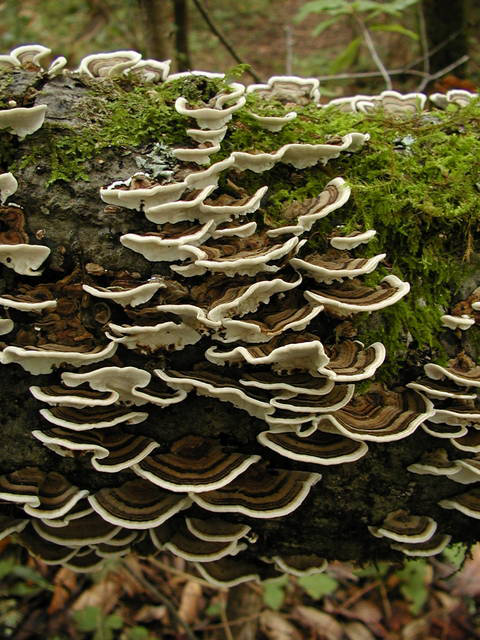

In [38]:
im = Image.open(PATH/'mo'/fn)
im

Turkey tails! What a classic.